In [1]:
#import the library
import pandas as pd
import numpy as np
import time
import re
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import nltk
import string
from nltk.corpus import stopwords
from nltk.corpus import wordnet as wn

from collections import defaultdict

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer, CountVectorizer

from sklearn.decomposition import LatentDirichletAllocation as LDA

# Import Data
Create training and testing datasets

In [2]:
#load the data
path = "../../01_Data/07_NIPS_ArXiv/arxiv-metadata-oai-snapshot.json"
metadata = pd.read_json(path, lines = True)

In [3]:
metadata.columns.tolist()

['id',
 'submitter',
 'authors',
 'title',
 'comments',
 'journal-ref',
 'doi',
 'report-no',
 'categories',
 'license',
 'abstract',
 'versions',
 'update_date',
 'authors_parsed']

In [4]:
metadata.shape

(1753042, 14)

In [5]:
#select paper in machine learning category
df_ml = metadata[metadata["categories"].str.contains("cs.LG")]

In [6]:
df_ml.shape

(63516, 14)

In [7]:
df_ml.head()

,id,submitter,authors,title,comments,journal-ref,doi,report-no,categories,license,abstract,versions,update_date,authors_parsed
670,0704.0671,Maxim Raginsky,Maxim Raginsky,Learning from compressed observations,6 pages; submitted to the 2007 IEEE Informatio...,None,10.1109/ITW.2007.4313111,None,cs.IT cs.LG math.IT,None,The problem of statistical learning is to co...,"[{'version': 'v1', 'created': 'Thu, 5 Apr 2007...",2016-11-15,"[[Raginsky, Maxim, ]]"
953,0704.0954,Jos\'e M. F. Moura,Soummya Kar and Jose M. F. Moura,Sensor Networks with Random Links: Topology De...,Submitted to IEEE Transactions,None,10.1109/TSP.2008.920143,None,cs.IT cs.LG math.IT,None,"In a sensor network, in practice, the commun...","[{'version': 'v1', 'created': 'Fri, 6 Apr 2007...",2009-11-13,"[[Kar, Soummya, ], [Moura, Jose M. F., ]]"
1019,0704.1020,Gyorgy Ottucsak,"Andras Gyorgy, Tamas Linder, Gabor Lugosi, Gyo...",The on-line shortest path problem under partia...,35 pages,None,None,None,cs.LG cs.SC,None,The on-line shortest path problem is conside...,"[{'version': 'v1', 'created': 'Sun, 8 Apr 2007...",2007-05-23,"[[Gyorgy, Andras, ], [Linder, Tamas, ], [Lugos..."
1027,0704.1028,Jianlin Cheng,Jianlin Cheng,A neural network approach to ordinal regression,8 pages,None,None,None,cs.LG cs.AI cs.NE,None,Ordinal regression is an important type of l...,"[{'version': 'v1', 'created': 'Sun, 8 Apr 2007...",2007-05-23,"[[Cheng, Jianlin, ]]"
1273,0704.1274,Dev Rajnarayan,David H. Wolpert and Dev G. Rajnarayan,Parametric Learning and Monte Carlo Optimization,None,None,None,None,cs.LG,None,This paper uncovers and explores the close r...,"[{'version': 'v1', 'created': 'Tue, 10 Apr 200...",2011-11-09,"[[Wolpert, David H., ], [Rajnarayan, Dev G., ]]"


In [10]:
#load the manually labeled data
path = "../../01_Data/07_NIPS_ArXiv/csLG_12302018.tsv.txt"

In [11]:
df_100 = pd.read_csv(path, delimiter="\t", header = 0, dtype=object)

In [12]:
df_100.columns = ['id','title','umCitation', 'zscore','description','task','subtask', 'method', 'submethod', 'goal','subgoal','other1','other2']

In [13]:
df_100.head(3)

,id,title,umCitation,zscore,description,task,subtask,method,submethod,goal,subgoal,other1,other2
0,1710.10196,Progressive Growing of GANs for Improved Quali...,340,zscore: 16.409013,We describe a new training methodology for gen...,Image,NaN,GAN,NaN,Better accuracy,NaN,NaN,NaN
1,1707.06347,Proximal Policy Optimization Algorithms,389,zscore: 12.533504,We propose a new family of policy gradient met...,Various,NaN,Reinforcement Learning,NaN,Better accuracy,NaN,NaN,NaN
2,1804.09541,QANet: Combining Local Convolution with Global...,52,zscore: 12.394387,Current end-to-end machine reading and questio...,Text,QA,Deep Learning,Architectures (Attention),Faster,NaN,NaN,NaN


In [15]:
df_100.shape

(100, 13)

In [16]:
#The papers with same id
df_ml1 = df_ml[df_ml['id'].isin(df_100['id'])]

In [18]:
#The papers with different id
df_100_res = df_100[~df_100['id'].isin(df_ml1['id'])]

In [19]:
df_100_res

,id,title,umCitation,zscore,description,task,subtask,method,submethod,goal,subgoal,other1,other2
5,1709.0656,Deep Reinforcement Learning that Matters,118,zscore: 9.394803,"In recent years, significant progress has been...",Various,NaN,Reinforcement Learning,NaN,Exposing Weaknesses,of researchers,NaN,NaN
7,1705.0775,"Quo Vadis, Action Recognition? A New Model and...",245,zscore: 9.215116,The paucity of videos in current action classi...,Video,NaN,Data,NaN,Better/more difficult data,NaN,NaN,NaN
15,1706.085,GANs Trained by a Two Time-Scale Update Rule C...,132,zscore: 7.234329,Generative Adversarial Networks (GANs) excel a...,Image,NaN,GAN,NaN,Better accuracy,NaN,NaN,NaN
59,1805.0362,On the Limitations of Unsupervised Bilingual D...,12,zscore: 4.464601,"Unsupervised machine translation---i.e., not a...",Text,NaN,Representation Learning,NaN,Better accuracy,NaN,NaN,NaN
68,1805.0477,Born Again Neural Networks,15,zscore: 4.146757,Knowledge distillation (KD) consists of transf...,Image,NaN,Distillation,NaN,Better accuracy,NaN,NaN,NaN
78,1712.0569,Sockeye: A Toolkit for Neural Machine Translation,48,zscore: 3.998110,"We describe Sockeye (version 1.12), an open-so...",Text,NaN,Generation,Seq2Seq,Toolkit,NaN,NaN,NaN
86,1801.0786,Scalable and accurate deep learning for electr...,24,zscore: 3.817276,Predictive modeling with electronic health rec...,Other,Health,Deep Learning,NaN,Better accuracy,NaN,NaN,NaN
96,1802.0348,GraphVAE: Towards Generation of Small Graphs U...,24,zscore: 3.631244,Deep learning on graphs has become a popular r...,Graphs,NaN,Representation Learning,NaN,Better accuracy,NaN,NaN,NaN


In [20]:
for id in df_100_res.id:
    print (id, df_ml['id'][df_ml['id'].str.contains(id)].tolist())

1709.0656 ['1709.06560']
1705.0775 ['1705.07750']
1706.085 ['1706.08500', '1706.08519', '1706.08580']
1805.0362 ['1805.03620']
1805.0477 ['1805.04770']
1712.0569 ['1712.05690', '1712.05695']
1801.0786 ['1801.07860', '1801.07861', '1801.07863']
1802.0348 ['1802.03480', '1802.03482', '1802.03486', '1802.03487', '1802.03488']


In [21]:
df_100_res['id'][df_100_res.id == '1706.085'] = '1706.0850'

C:\Users\Hugo\Anaconda3\lib\site-packages\pandas\core\generic.py:8765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


In [22]:
df_100['id'][df_100.id == '1706.085'] = '1706.0850'

In [23]:
for id in df_100_res.id:
    print (id, df_ml['id'][df_ml['id'].str.contains(id)].tolist())

1709.0656 ['1709.06560']
1705.0775 ['1705.07750']
1706.0850 ['1706.08500']
1805.0362 ['1805.03620']
1805.0477 ['1805.04770']
1712.0569 ['1712.05690', '1712.05695']
1801.0786 ['1801.07860', '1801.07861', '1801.07863']
1802.0348 ['1802.03480', '1802.03482', '1802.03486', '1802.03487', '1802.03488']


In [24]:
#fixed the id difference
df_100['id'][df_100['id'].isin(df_100_res['id'])] = df_100['id'][df_100['id'].isin(df_100_res['id'])].apply(lambda x: x+'0')

In [25]:
#fix the id difference
df_100_res['id'][df_100_res['id'].isin(df_100_res['id'])] = df_100_res['id'][df_100_res['id'].isin(df_100_res['id'])].apply(lambda x: x+'0')

In [26]:
#test dataset
df_ml_100 = df_ml[df_ml['id'].isin(df_100['id'])]

In [30]:
#join df_ml_test and df_100
df_ml_test_label = df_ml_test.merge(df_100, left_on = 'id', right_on = 'id')

In [35]:
df_ml_test_label.head()

,id,submitter,authors,title_x,comments,journal-ref,doi,report-no,categories,license,...,zscore,description,task,subtask,method,submethod,goal,subgoal,other1,other2
0,1705.02801,Palash Goyal,"Palash Goyal, Emilio Ferrara","Graph Embedding Techniques, Applications, and ...",Submitted to Knowledge Based Systems for review,"Knowledge Based Systems, Volume 151, 1 July 20...",10.1016/j.knosys.2018.03.022,None,cs.SI cs.LG physics.data-an,http://arxiv.org/licenses/nonexclusive-distrib...,...,zscore: 6.597314,"Graphs, such as social networks, word co-occur...",Graphs,NaN,Representation Learning,NaN,Review,NaN,NaN,NaN
1,1705.07204,Florian Tram\`er,"Florian Tram\`er, Alexey Kurakin, Nicolas Pape...",Ensemble Adversarial Training: Attacks and Def...,"22 pages, 5 figures, International Conference ...",None,None,None,stat.ML cs.CR cs.LG,http://arxiv.org/licenses/nonexclusive-distrib...,...,zscore: 7.748311,Adversarial examples are perturbed inputs desi...,Image,NaN,Adversarial,Attacks,Exposing Weaknesses,NaN,NaN,NaN
2,1705.07263,Nicholas Carlini,"Nicholas Carlini, David Wagner",Adversarial Examples Are Not Easily Detected: ...,None,None,None,None,cs.LG cs.CR cs.CV,http://arxiv.org/licenses/nonexclusive-distrib...,...,zscore: 7.150224,Neural networks are known to be vulnerable to ...,Various,NaN,GAN,NaN,Exposing Weaknesses,NaN,NaN,NaN
3,1705.07750,Joao Carreira,Joao Carreira and Andrew Zisserman,"Quo Vadis, Action Recognition? A New Model and...",Removed references to mini-kinetics dataset th...,None,None,None,cs.CV cs.LG,http://arxiv.org/licenses/nonexclusive-distrib...,...,zscore: 9.215116,The paucity of videos in current action classi...,Video,NaN,Data,NaN,Better/more difficult data,NaN,NaN,NaN
4,1705.09064,Dongyu Meng,"Dongyu Meng, Hao Chen",MagNet: a Two-Pronged Defense against Adversar...,Accepted at the ACM Conference on Computer and...,None,None,None,cs.CR cs.LG,http://arxiv.org/licenses/nonexclusive-distrib...,...,zscore: 4.263524,Deep learning has shown promising results on h...,Image,NaN,Adversarial,Attacks,Robustness,NaN,NaN,NaN


In [125]:
df_ml_test_label.to_csv('test_label_20200917.csv')

In [112]:
df_ml_100.shape

(100, 17)

In [36]:
df_ml_test_label.columns

Index(['id', 'submitter', 'authors', 'title_x', 'comments', 'journal-ref',
       'doi', 'report-no', 'categories', 'license', 'abstract', 'versions',
       'update_date', 'authors_parsed', 'title_y', 'umCitation', 'zscore',
       'description', 'task', 'subtask', 'method', 'submethod', 'goal',
       'subgoal', 'other1', 'other2'],
      dtype='object')

In [42]:
#training dataset
df_ml_train = df_ml[~df_ml['id'].isin(df_100['id'])]
df_ml_train.shape

(63416, 14)

In [43]:
df_ml_train.head()

,id,submitter,authors,title,comments,journal-ref,doi,report-no,categories,license,abstract,versions,update_date,authors_parsed
670,0704.0671,Maxim Raginsky,Maxim Raginsky,Learning from compressed observations,6 pages; submitted to the 2007 IEEE Informatio...,None,10.1109/ITW.2007.4313111,None,cs.IT cs.LG math.IT,None,The problem of statistical learning is to co...,"[{'version': 'v1', 'created': 'Thu, 5 Apr 2007...",2016-11-15,"[[Raginsky, Maxim, ]]"
953,0704.0954,Jos\'e M. F. Moura,Soummya Kar and Jose M. F. Moura,Sensor Networks with Random Links: Topology De...,Submitted to IEEE Transactions,None,10.1109/TSP.2008.920143,None,cs.IT cs.LG math.IT,None,"In a sensor network, in practice, the commun...","[{'version': 'v1', 'created': 'Fri, 6 Apr 2007...",2009-11-13,"[[Kar, Soummya, ], [Moura, Jose M. F., ]]"
1019,0704.1020,Gyorgy Ottucsak,"Andras Gyorgy, Tamas Linder, Gabor Lugosi, Gyo...",The on-line shortest path problem under partia...,35 pages,None,None,None,cs.LG cs.SC,None,The on-line shortest path problem is conside...,"[{'version': 'v1', 'created': 'Sun, 8 Apr 2007...",2007-05-23,"[[Gyorgy, Andras, ], [Linder, Tamas, ], [Lugos..."
1027,0704.1028,Jianlin Cheng,Jianlin Cheng,A neural network approach to ordinal regression,8 pages,None,None,None,cs.LG cs.AI cs.NE,None,Ordinal regression is an important type of l...,"[{'version': 'v1', 'created': 'Sun, 8 Apr 2007...",2007-05-23,"[[Cheng, Jianlin, ]]"
1273,0704.1274,Dev Rajnarayan,David H. Wolpert and Dev G. Rajnarayan,Parametric Learning and Monte Carlo Optimization,None,None,None,None,cs.LG,None,This paper uncovers and explores the close r...,"[{'version': 'v1', 'created': 'Tue, 10 Apr 200...",2011-11-09,"[[Wolpert, David H., ], [Rajnarayan, Dev G., ]]"


# Exploratory Data Analysis 

In [44]:
#drop duplicates
print(df_ml_train.shape)
df_ml_train.drop_duplicates(subset = ['title'], keep='last')
print(df_ml_train.shape)

(63416, 14)
(63416, 14)


In [45]:
#create year, month, day
df_ml_train['year'] = pd.to_datetime(df_ml_train.update_date).dt.year
df_ml_train['month'] = pd.to_datetime(df_ml_train.update_date).dt.month
df_ml_train['day'] = pd.to_datetime(df_ml_train.update_date).dt.day

C:\Users\Hugo\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\Hugo\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Hugo\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = valu

In [50]:
#create year, month, day
df_ml_test['year'] = pd.to_datetime(df_ml_test.update_date).dt.year
df_ml_test['month'] = pd.to_datetime(df_ml_test.update_date).dt.month
df_ml_test['day'] = pd.to_datetime(df_ml_test.update_date).dt.day

C:\Users\Hugo\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\Hugo\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Hugo\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = valu

In [46]:
df_ml_train.head()

,id,submitter,authors,title,comments,journal-ref,doi,report-no,categories,license,abstract,versions,update_date,authors_parsed,year,month,day
670,0704.0671,Maxim Raginsky,Maxim Raginsky,Learning from compressed observations,6 pages; submitted to the 2007 IEEE Informatio...,None,10.1109/ITW.2007.4313111,None,cs.IT cs.LG math.IT,None,The problem of statistical learning is to co...,"[{'version': 'v1', 'created': 'Thu, 5 Apr 2007...",2016-11-15,"[[Raginsky, Maxim, ]]",2016,11,15
953,0704.0954,Jos\'e M. F. Moura,Soummya Kar and Jose M. F. Moura,Sensor Networks with Random Links: Topology De...,Submitted to IEEE Transactions,None,10.1109/TSP.2008.920143,None,cs.IT cs.LG math.IT,None,"In a sensor network, in practice, the commun...","[{'version': 'v1', 'created': 'Fri, 6 Apr 2007...",2009-11-13,"[[Kar, Soummya, ], [Moura, Jose M. F., ]]",2009,11,13
1019,0704.1020,Gyorgy Ottucsak,"Andras Gyorgy, Tamas Linder, Gabor Lugosi, Gyo...",The on-line shortest path problem under partia...,35 pages,None,None,None,cs.LG cs.SC,None,The on-line shortest path problem is conside...,"[{'version': 'v1', 'created': 'Sun, 8 Apr 2007...",2007-05-23,"[[Gyorgy, Andras, ], [Linder, Tamas, ], [Lugos...",2007,5,23
1027,0704.1028,Jianlin Cheng,Jianlin Cheng,A neural network approach to ordinal regression,8 pages,None,None,None,cs.LG cs.AI cs.NE,None,Ordinal regression is an important type of l...,"[{'version': 'v1', 'created': 'Sun, 8 Apr 2007...",2007-05-23,"[[Cheng, Jianlin, ]]",2007,5,23
1273,0704.1274,Dev Rajnarayan,David H. Wolpert and Dev G. Rajnarayan,Parametric Learning and Monte Carlo Optimization,None,None,None,None,cs.LG,None,This paper uncovers and explores the close r...,"[{'version': 'v1', 'created': 'Tue, 10 Apr 200...",2011-11-09,"[[Wolpert, David H., ], [Rajnarayan, Dev G., ]]",2011,11,9


Text(0.5, 0, 'Year')

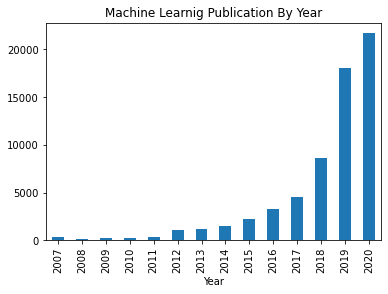

In [47]:
#check the paper numbers by year
year_groups = df_ml_train.groupby('year')
counts = year_groups.size()

counts.plot(kind='bar')
plt.title('Machine Learnig Publication By Year')
plt.xlabel('Year')

Text(0.5, 0, 'Year')

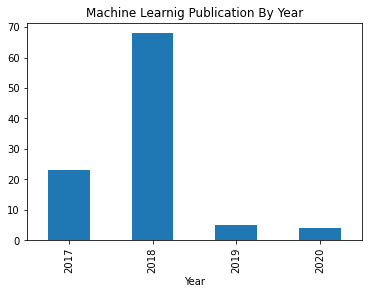

In [51]:
#check the paper numbers by year
year_groups = df_ml_test.groupby('year')
counts = year_groups.size()

counts.plot(kind='bar')
plt.title('Machine Learnig Publication By Year')
plt.xlabel('Year')

# Preprocessing text data

In [61]:
for entry in df_ml_train['abstract'].iloc[2:3]:
    print(entry)

  The on-line shortest path problem is considered under various models of
partial monitoring. Given a weighted directed acyclic graph whose edge weights
can change in an arbitrary (adversarial) way, a decision maker has to choose in
each round of a game a path between two distinguished vertices such that the
loss of the chosen path (defined as the sum of the weights of its composing
edges) be as small as possible. In a setting generalizing the multi-armed
bandit problem, after choosing a path, the decision maker learns only the
weights of those edges that belong to the chosen path. For this problem, an
algorithm is given whose average cumulative loss in n rounds exceeds that of
the best path, matched off-line to the entire sequence of the edge weights, by
a quantity that is proportional to 1/\sqrt{n} and depends only polynomially on
the number of edges of the graph. The algorithm can be implemented with linear
complexity in the number of rounds n and in the number of edges. An extensio

In [52]:
#lemmatazation operator
lemmatizer = nltk.WordNetLemmatizer()

In [53]:
#define the stop words
stop = stopwords.words('english')

In [54]:
#remove punctuations
translation = str.maketrans(string.punctuation, ' '*len(string.punctuation))

In [83]:
#tokenize
def preprocessing(line):
    tag_map = defaultdict(lambda:wn.NOUN)
    tag_map['J'] = wn.ADJ
    tag_map['V'] = wn.VERB
    tag_map['R'] = wn.ADV
    
    tokens = []
    line = str(line).translate(translation)
    line = re.sub('\n', ' ', str(line))
    line = nltk.word_tokenize(line.lower())
    
    for t, tag in nltk.pos_tag(line):
        if t not in stop and len(t)>1:
            stemmed = lemmatizer.lemmatize(t, tag_map[tag[0]])
            tokens.append(stemmed)
    return ' '.join(tokens)
    

In [66]:
df_tmp = df_ml_train.iloc[:10]

In [67]:
df_tmp.head()

,id,submitter,authors,title,comments,journal-ref,doi,report-no,categories,license,abstract,versions,update_date,authors_parsed,year,month,day,bow
670,0704.0671,Maxim Raginsky,Maxim Raginsky,Learning from compressed observations,6 pages; submitted to the 2007 IEEE Informatio...,None,10.1109/ITW.2007.4313111,None,cs.IT cs.LG math.IT,None,The problem of statistical learning is to co...,"[{'version': 'v1', 'created': 'Thu, 5 Apr 2007...",2016-11-15,"[[Raginsky, Maxim, ]]",2016,11,15,NaN
953,0704.0954,Jos\'e M. F. Moura,Soummya Kar and Jose M. F. Moura,Sensor Networks with Random Links: Topology De...,Submitted to IEEE Transactions,None,10.1109/TSP.2008.920143,None,cs.IT cs.LG math.IT,None,"In a sensor network, in practice, the commun...","[{'version': 'v1', 'created': 'Fri, 6 Apr 2007...",2009-11-13,"[[Kar, Soummya, ], [Moura, Jose M. F., ]]",2009,11,13,NaN
1019,0704.1020,Gyorgy Ottucsak,"Andras Gyorgy, Tamas Linder, Gabor Lugosi, Gyo...",The on-line shortest path problem under partia...,35 pages,None,None,None,cs.LG cs.SC,None,The on-line shortest path problem is conside...,"[{'version': 'v1', 'created': 'Sun, 8 Apr 2007...",2007-05-23,"[[Gyorgy, Andras, ], [Linder, Tamas, ], [Lugos...",2007,5,23,NaN
1027,0704.1028,Jianlin Cheng,Jianlin Cheng,A neural network approach to ordinal regression,8 pages,None,None,None,cs.LG cs.AI cs.NE,None,Ordinal regression is an important type of l...,"[{'version': 'v1', 'created': 'Sun, 8 Apr 2007...",2007-05-23,"[[Cheng, Jianlin, ]]",2007,5,23,NaN
1273,0704.1274,Dev Rajnarayan,David H. Wolpert and Dev G. Rajnarayan,Parametric Learning and Monte Carlo Optimization,None,None,None,None,cs.LG,None,This paper uncovers and explores the close r...,"[{'version': 'v1', 'created': 'Tue, 10 Apr 200...",2011-11-09,"[[Wolpert, David H., ], [Rajnarayan, Dev G., ]]",2011,11,9,NaN


In [84]:
start = time.time()
df_tmp['bow'] = df_tmp['abstract'].apply(lambda x:preprocessing(x))
end  = time.time()

C:\Users\Hugo\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [85]:
print(df_tmp['abstract'].iloc[2:3].tolist())

['  The on-line shortest path problem is considered under various models of\npartial monitoring. Given a weighted directed acyclic graph whose edge weights\ncan change in an arbitrary (adversarial) way, a decision maker has to choose in\neach round of a game a path between two distinguished vertices such that the\nloss of the chosen path (defined as the sum of the weights of its composing\nedges) be as small as possible. In a setting generalizing the multi-armed\nbandit problem, after choosing a path, the decision maker learns only the\nweights of those edges that belong to the chosen path. For this problem, an\nalgorithm is given whose average cumulative loss in n rounds exceeds that of\nthe best path, matched off-line to the entire sequence of the edge weights, by\na quantity that is proportional to 1/\\sqrt{n} and depends only polynomially on\nthe number of edges of the graph. The algorithm can be implemented with linear\ncomplexity in the number of rounds n and in the number of edg

In [86]:
print(df_tmp['bow'].iloc[2:3].tolist())

['line short path problem consider various model partial monitoring give weighted directed acyclic graph whose edge weight change arbitrary adversarial way decision maker choose round game path two distinguished vertex loss chosen path define sum weight composing edge small possible setting generalize multi arm bandit problem choose path decision maker learn weight edge belong choose path problem algorithm give whose average cumulative loss round exceed best path match line entire sequence edge weight quantity proportional sqrt depend polynomially number edge graph algorithm implement linear complexity number round number edge extension called label efficient setting also give decision maker inform weight edge correspond choose path total time instance another extension show decision maker compete time vary path generalization problem track best expert version multi arm bandit set short path also discuss decision maker learn total weight chosen path weight individual edge path applicat

In [87]:
start = time.time()
df_ml_train['bow'] = df_ml_train['abstract'].apply(lambda x:preprocessing(x))
end  = time.time()

C:\Users\Hugo\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [88]:
print(end-start)

691.4565777778625


In [91]:
for entry in df_ml_train['bow'].iloc[:10]:
    print(entry)

problem statistical learning construct predictor random variable function related random variable basis train sample joint distribution allowable predictor draw specify class goal approach asymptotically performance expect loss best predictor class consider setting one perfect observation part sample part communicate finite bit rate encoding value allow depend value suitable regularity condition admissible predictor underlie family probability distribution loss function give information theoretic characterization achievable predictor performance term conditional distortion rate function idea illustrate example nonparametric regression gaussian noise
sensor network practice communication among sensor subject error failure random time cost constraint since sensor network operate scarce resource power data rate communication signal noise ratio snr usually main factor determine probability error communication failure link probability proxy snr link operate paper study problem design topolo

In [92]:
t = []
start = time.time()
for line in df_ml_train['bow']:
    l = nltk.word_tokenize(line)
    for w in l:
        t.append(w)
word_feature = nltk.FreqDist(t)
end = time.time()
print(end-start)

37.42892074584961


In [94]:
word_feature.most_common(10)

[('model', 91921),
 ('use', 65705),
 ('data', 64973),
 ('network', 60313),
 ('method', 59782),
 ('learn', 59062),
 ('propose', 53499),
 ('algorithm', 46100),
 ('base', 42489),
 ('show', 40477)]

In [95]:
topwords = [fpair[0] for fpair in list(word_feature.most_common(5000))]

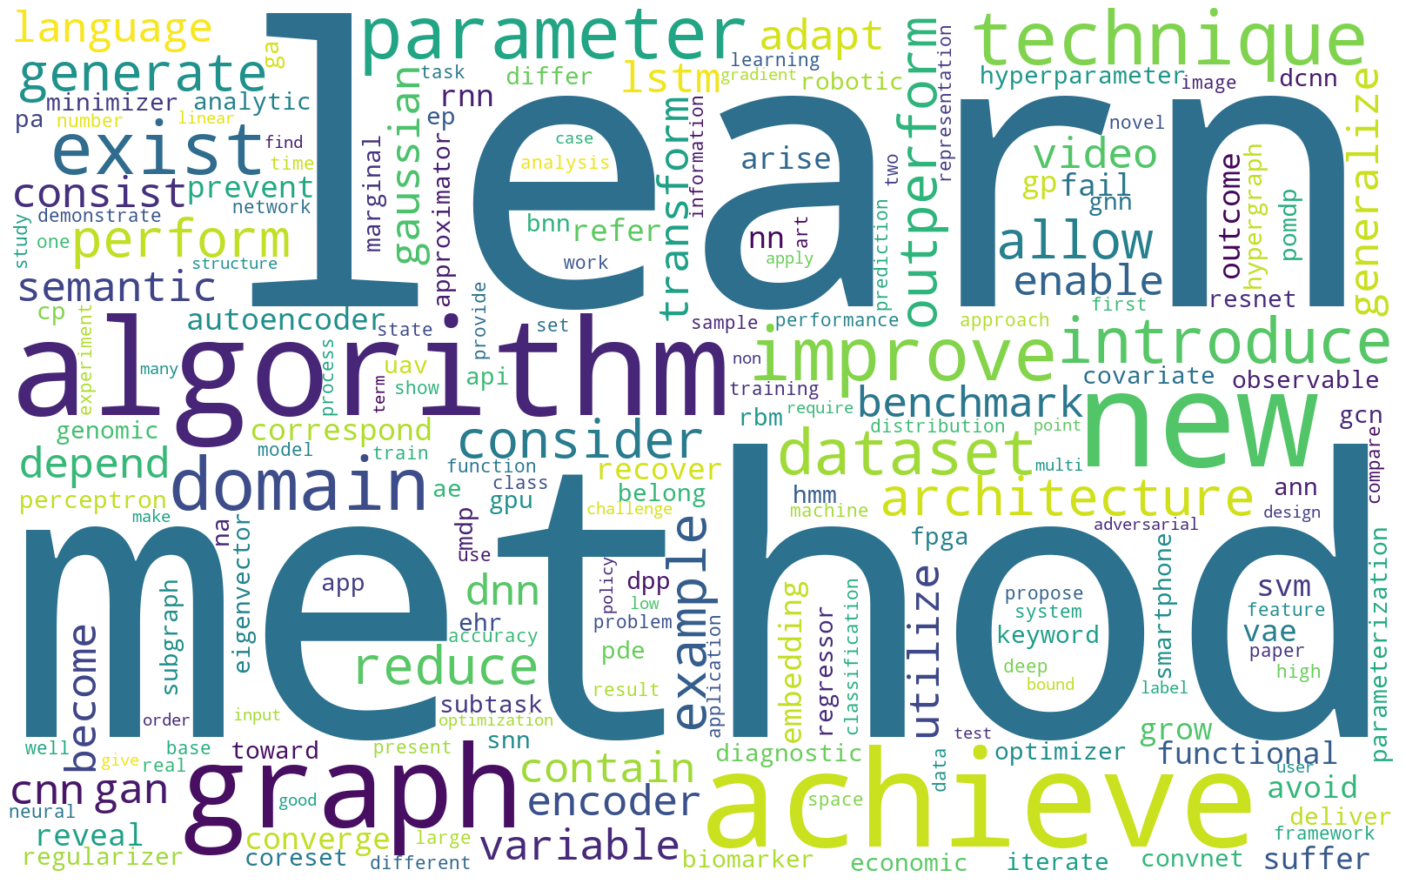

In [96]:
#word cloud
wordcloud = WordCloud(width = 1600, height = 1000, max_font_size = 3000, \
                      max_words = 200, background_color = 'white') \
                    .generate(' '.join(topwords))
plt.figure(figsize = (25,16))
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.show()

In [97]:
tf_vec = TfidfVectorizer(vocabulary=topwords)

In [98]:
start = time.time()
train_features = tf_vec.fit_transform(df_ml_train['bow'])

In [101]:
import gensim
from gensim.test.utils import common_texts
from gensim.corpora.dictionary import Dictionary

In [102]:
common_dictionary = Dictionary(df_ml_train['bow'].apply(lambda x:x.split()))

In [103]:
common_dictionary.filter_extremes(keep_n=5000)

In [104]:
common_dictionary.token2id

{'achievable': 0,
 'allow': 1,
 'approach': 2,
 'asymptotically': 3,
 'basis': 4,
 'best': 5,
 'bit': 6,
 'characterization': 7,
 'class': 8,
 'communicate': 9,
 'condition': 10,
 'conditional': 11,
 'consider': 12,
 'construct': 13,
 'depend': 14,
 'distortion': 15,
 'distribution': 16,
 'draw': 17,
 'encoding': 18,
 'example': 19,
 'expect': 20,
 'family': 21,
 'finite': 22,
 'function': 23,
 'gaussian': 24,
 'give': 25,
 'goal': 26,
 'idea': 27,
 'illustrate': 28,
 'information': 29,
 'joint': 30,
 'learning': 31,
 'loss': 32,
 'noise': 33,
 'nonparametric': 34,
 'observation': 35,
 'one': 36,
 'part': 37,
 'perfect': 38,
 'performance': 39,
 'predictor': 40,
 'probability': 41,
 'problem': 42,
 'random': 43,
 'rate': 44,
 'regression': 45,
 'regularity': 46,
 'related': 47,
 'sample': 48,
 'setting': 49,
 'specify': 50,
 'statistical': 51,
 'suitable': 52,
 'term': 53,
 'theoretic': 54,
 'train': 55,
 'underlie': 56,
 'value': 57,
 'variable': 58,
 'account': 59,
 'achieve': 60,
 '

In [106]:
corpus = [common_dictionary.doc2bow(text) for text in df_ml_train['bow'].apply(lambda x:x.split())]

In [107]:
start = time.time()
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=common_dictionary,
                                           num_topics=10, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=10,
                                           passes=10,
                                           alpha='symmetric',
                                           iterations=100,
                                           per_word_topics=True)
end = time.time()
print(end-start)

1078.9612612724304


In [108]:
from pprint import pprint

In [109]:
pprint(lda_model.print_topics())

[(0,
  '0.043*"learn" + 0.042*"algorithm" + 0.039*"multi" + 0.035*"sequence" + '
  '0.035*"decision" + 0.034*"policy" + 0.027*"reinforcement" + '
  '0.025*"adversarial" + 0.017*"game" + 0.014*"privacy"'),
 (1,
  '0.041*"function" + 0.029*"distribution" + 0.020*"loss" + 0.018*"estimate" + '
  '0.016*"measure" + 0.016*"sample" + 0.015*"show" + 0.015*"probability" + '
  '0.015*"class" + 0.014*"source"'),
 (2,
  '0.074*"algorithm" + 0.039*"problem" + 0.024*"bound" + 0.021*"set" + '
  '0.021*"point" + 0.018*"sample" + 0.015*"result" + 0.014*"number" + '
  '0.014*"give" + 0.014*"high"'),
 (3,
  '0.038*"framework" + 0.035*"method" + 0.035*"real" + 0.025*"language" + '
  '0.023*"world" + 0.018*"include" + 0.017*"good" + 0.017*"space" + '
  '0.016*"compute" + 0.014*"selection"'),
 (4,
  '0.025*"learning" + 0.018*"system" + 0.016*"time" + 0.015*"learn" + '
  '0.015*"present" + 0.011*"problem" + 0.011*"result" + 0.010*"state" + '
  '0.010*"show" + 0.009*"approach"'),
 (5,
  '0.045*"user" + 0.042*

In [110]:
import pyLDAvis
import pyLDAvis.gensim

In [111]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, common_dictionary)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
7     -0.173666 -0.144080       1        1  27.845654
4     -0.153348  0.086909       2        1  22.550644
8     -0.136003 -0.078248       3        1  13.431309
1      0.211452  0.045595       4        1   8.475237
2     -0.081708  0.085460       5        1   8.114991
3     -0.010054 -0.275130       6        1   6.781781
5      0.025735  0.276972       7        1   5.040959
0      0.022981  0.181980       8        1   4.675179
6      0.387025 -0.116085       9        1   2.979966
9     -0.092413 -0.063373      10        1   0.104284, topic_info=            Term          Freq         Total Category  logprob  loglift
99       network  53557.000000  53557.000000  Default  30.0000  30.0000
63     algorithm  50780.000000  50780.000000  Default  29.0000  29.0000
176        learn  56999.000000  56999.000000  Default  28.0000  28.0000
233       method  55691.000000  55691.000000  Default  27.0000  27.0000
42       problem  39790.000000  39790.000000  Default  26.0000  26.0000
...          ...           ...           ...      ...      ...      ...
2978      surely      1.257551      5.150788  Topic10  -8.5169   5.4558
4118      usable      1.257550      2.332509  Topic10  -8.5170   6.2480
4964      impair      1.257525      2.331618  Topic10  -8.5170   6.2484
4353      instal      1.257522      2.278606  Topic10  -8.5170   6.2714
3205  excitation      1.257515      2.423721  Topic10  -8.5170   6.2096

[521 rows x 6 columns], token_table=      Topic      Freq   Term
term                        
3642      3  0.999421     19
3642     10  0.000273     19
3977      5  0.380534   2003
3977      8  0.190267   2003
3977     10  0.190267   2003
...     ...       ...    ...
598      10  0.000056   work
432       6  0.999822  world
432      10  0.000108  world
960       9  0.999134  would
960      10  0.000422  would

[1016 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[8, 5, 9, 2, 3, 4, 6, 1, 7, 10])